# Data Preparation

## First look at the data

In [ ]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

First, columns names have been assigned to each column.

In [ ]:
cols = ['id','sentiment','text']

In [ ]:
df = pd.read_csv("/content/sample_data/StackOverflow.csv")

In [ ]:
df.head()

,id,sentiment,text
0,6,-1,But sadly this is not working.
1,78,-1,"So, everything builds fine, but when we try to..."
2,90,-1,That is what is causing your null pointer exce...
3,139,-1,"All attempts I've made were, in a shortcut, un..."
4,162,-1,Don't use.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1500 non-null   int64 
 1   sentiment  1500 non-null   int64 
 2   text       1500 non-null   object
dtypes: int64(2), object(1)
memory usage: 35.3+ KB


In [ ]:
df.sentiment.value_counts()

 0    1191
-1     178
 1     131
Name: sentiment, dtype: int64

In [ ]:
df.drop(['id'],axis=1,inplace=True)

In [ ]:
df.head()

,sentiment,text
0,-1,But sadly this is not working.
1,-1,"So, everything builds fine, but when we try to..."
2,-1,That is what is causing your null pointer exce...
3,-1,"All attempts I've made were, in a shortcut, un..."
4,-1,Don't use.


In [ ]:
df[df.sentiment == 0].head(10)

,sentiment,text
178,0,Perfect would be to have in my CODE_FRAGMENT.
179,0,and then override this with CODE_FRAGMENT so t...
180,0,Define your production environment as default ...
181,0,You can setup your API_NAME as filtered resour...
182,0,Now you can use.
183,0,About setting default production profile alrea...
184,0,So I do the following.
185,0,Many thanks.
186,0,Use this construct.
187,0,According to docs.


In [ ]:
df[df.sentiment == -1].head(10)

,sentiment,text
0,-1,But sadly this is not working.
1,-1,"So, everything builds fine, but when we try to..."
2,-1,That is what is causing your null pointer exce...
3,-1,"All attempts I've made were, in a shortcut, un..."
4,-1,Don't use.
5,-1,"However when I try to run FILE_NAME, it gives ..."
6,-1,"Problem: without zooming, the added content do..."
7,-1,in a application you can workaround with scali...
8,-1,else your GUI will be Hanged.
9,-1,I am not sure about Map implementation in Haze...


By looking at some entries for each class, it seems like that all the negative class is from 0~799999th index,
and the positive class entries start from 800000 to the end of the dataset.

In [ ]:
df[df.sentiment == 0].index

Int64Index([ 178,  179,  180,  181,  182,  183,  184,  185,  186,  187,
            ...
            1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368],
           dtype='int64', length=1191)

In [ ]:
df[df.sentiment == -1].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            168, 169, 170, 171, 172, 173, 174, 175, 176, 177],
           dtype='int64', length=178)

In order for the computation, I mapped the class value of 4(positive) to 1.

In [ ]:
df['sentiment'] = df['sentiment'].map({0: 1, -1: 0, 1: 2})

In [ ]:
df.sentiment.value_counts()

1    1191
0     178
2     131
Name: sentiment, dtype: int64

# Data Preparation

As a way of sanity check, let's look at the length of the string in text column in each entry.

In [ ]:
df['pre_clean_len'] = [len(t) for t in df.text]

## Data Dictionary - first draft

Below is the first draft of the data dictionary for the dataset, but as I go through preparation, this will need to be updated.

In [ ]:
from pprint import pprint
data_dict = {
    'sentiment':{
        'type':df.sentiment.dtype,
        'description':'sentiment class - -1:negative, 0:neutral, 1:positive'
    },
    'text':{
        'type':df.text.dtype,
        'description':'post text'
    },
    'pre_clean_len':{
        'type':df.pre_clean_len.dtype,
        'description':'Stack Overflow Post'
    },
    'dataset_shape':df.shape
}

pprint(data_dict)

{'dataset_shape': (1500, 3),
 'pre_clean_len': {'description': 'Stack Overflow Post',
                   'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - -1:negative, 0:neutral, '
                              '1:positive',
               'type': dtype('int64')},
 'text': {'description': 'post text', 'type': dtype('O')}}


 I will also plot pre_clean_len with box plot, so that I can see the overall distribution of length of strings in each entry.

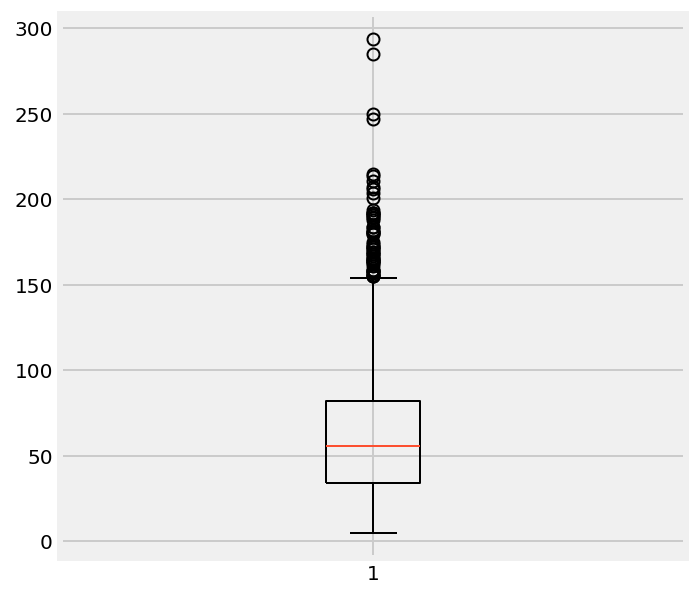

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

In [ ]:
df[df.pre_clean_len > 140].head(10)

,sentiment,text,pre_clean_len
19,0,"For some mystic reason, the workflow is not en...",157
26,0,"After entering the details, when the button is...",141
32,0,I wanted to see all the files I have in my ext...,184
33,0,"A workaround might be to use reflection, howev...",184
36,0,It is not advisable to avoid an exception with...,153
37,0,You are really asking too much of the Java run...,206
48,0,An SQL EXCEPTION is being caught saying API_NA...,150
63,0,But as far as I create the entitymanager - whi...,150
71,0,since a day I have a very annoying problem - I...,156
92,0,"I am using standout library, I added a videoVi...",192


## Data Preparation 1: HTML decoding

It looks like HTML encoding has not been converted to text, and ended up in text field as '&amp','&quot',etc.<br>
Decoding HTML to general text will be my first step of data preparation.
I will use BeautifulSoup for this.

In [ ]:
df.text[279]

'Try using equalsIgnoreCase instead of straight CODE_FRAGMENT.'

In [ ]:
from bs4 import BeautifulSoup
example1 = BeautifulSoup(df.text[279], 'lxml')
example1.get_text()

'Try using equalsIgnoreCase instead of straight CODE_FRAGMENT.'

## Data Preparation 2: @mention

The second part of the preparation is dealing with @mention.<br>
Even though @mention carries a certain information (which another user that the tweet mentioned),
this information doesn't add value to build sentiment analysis model.

In [ ]:
df.text[343]

'@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [ ]:
import re
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

## Data Preparation 3: URL links

The third part of the cleaning is dealing with URL links, same with @mention,
even though it carries some information, for sentiment analysis purpose,
this can be ignored.

In [ ]:
df.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [ ]:
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

## Data Preparation 4: UTF-8 BOM (Byte Order Mark)

In [ ]:
df.text[226]

'Tuesday\xef\xbf\xbdll start with reflection \xef\xbf\xbdn then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

By looking at the above entry, I can see strange patterns of characters "\xef\xbf\xbd" and these are UTF-8 BOM.<br>
"The UTF-8 BOM is a sequence of bytes (EF BB BF) that allows the reader to identify a file as being encoded in UTF-8."

By decoding text with 'utf-8-sig', this BOM will be replaced with unicode unrecognizable special characters

In [ ]:
testing = df.text[226].decode("utf-8-sig")
testing

u'Tuesday\ufffdll start with reflection \ufffdn then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [ ]:
testing.replace(u"\ufffd", "?")

u'Tuesday?ll start with reflection ?n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

## Data Preparation 5: hashtag / numbers

Sometimes the text used with a hashtag can provide useful information about the post. It might be a bit risky to get rid of all the text together with the hashtag.<br>
So I decided to remove the '#'. 

In [ ]:
df.text[175]

"@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail"

In [ ]:
re.sub("[^a-zA-Z]", " ", df.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

# Defining data cleaning function

With above five data cleaning task, I will first define data cleaning function, and then will be applied to the whole dataset. Tokenization, stemming/lemmatization, stop words will be dealt with later stage when creating matrix with either count vectorizer or Tfidf vectorizer.

In [ ]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

In [ ]:
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [ ]:
testing = df.text[:100]

In [ ]:
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))

In [ ]:
test_result

[u'awww that s a bummer you shoulda got david carr of third day to do it d',
 u'is upset that he can t update his facebook by texting it and might cry as a result school today also blah',
 u'i dived many times for the ball managed to save the rest go out of bounds',
 u'my whole body feels itchy and like its on fire',
 u'no it s not behaving at all i m mad why am i here because i can t see you all over there',
 u'not the whole crew',
 u'need a hug',
 u'hey long time no see yes rains a bit only a bit lol i m fine thanks how s you',
 u'k nope they didn t have it',
 u'que me muera',
 u'spring break in plain city it s snowing',
 u'i just re pierced my ears',
 u'i couldn t bear to watch it and i thought the ua loss was embarrassing',
 u'it it counts idk why i did either you never talk to me anymore',
 u'i would ve been the first but i didn t have a gun not really though zac snyder s just a doucheclown',
 u'i wish i got to watch it with you i miss you and how was the premiere',
 u'hollis deat

In [ ]:
nums = [0,500,1000,1500]

In [ ]:
print "Cleaning and parsing the posts...\n"
clean_tweet_texts = []
for i in xrange(nums[0],nums[1]):
    if( (i+1)%100 == 0 ):
        print "Posts %d of %d has been processed" % ( i+1, nums[1] )                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the posts...

Posts 100 of 500 has been processed
Posts 200 of 500 has been processed
Posts 300 of 500 has been processed
Posts 400 of 500 has been processed
Posts 500 of 500 has been processed


In [ ]:
print "Cleaning and parsing the posts...\n"
for i in xrange(nums[1],nums[2]):
    if( (i+1)%100 == 0 ):
        print "Posts %d of %d has been processed" % ( i+1, nums[2] )                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the posts...

Posts 600 of 1000 has been processed
Posts 700 of 1000 has been processed
Posts 800 of 1000 has been processed
Posts 900 of 1000 has been processed
Posts 1000 of 1000 has been processed


In [ ]:
print "Cleaning and parsing the posts...\n"
for i in xrange(nums[2],nums[3]):
    if( (i+1)%100 == 0 ):
        print "Posts %d of %d has been processed" % ( i+1, nums[3] )                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the posts...

Posts 1100 of 1500 has been processed
Posts 1200 of 1500 has been processed
Posts 1300 of 1500 has been processed
Posts 1400 of 1500 has been processed
Posts 1500 of 1500 has been processed


In [ ]:
len(clean_tweet_texts)

1500


## Saving cleaned data as csv

In [ ]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [ ]:
clean_df.to_csv('clean_stackoverflow_posts.csv',encoding='utf-8')

In [ ]:
csv = 'clean_stackoverflow_posts.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0
